In [162]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [163]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Try to find the lake in a White Island image
--

**Purpose**

To see if we can find the area of the lake at White Island.

**Method**

Use histogram backprojection to find parts of the image that have the same colours as a 'model' part of the image that is specified.

This follows http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/py_histogram_backprojection.html#histogram-backprojection

In [164]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

%matplotlib inline

**target image, this is the image in which we want to find the lake**

In [165]:
target = cv2.imread('20180131015002WIWR.jpg')

**specify the model (roi), the part of the image that sets the colour we use for the back-projection**

we'll use a 75x75 pixel area in the centre of the lake

In [166]:
#convert to hsv (hue, saturation, value)
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)

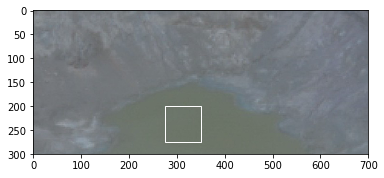

In [167]:
fig,ax = plt.subplots(1)
ax.imshow(target)
rect = patches.Rectangle((275,200),75,75,linewidth=1,edgecolor='white',facecolor='white', fill=False)
ax.add_patch(rect)

**crop the model from the target image and prepare**

In [168]:
#crop from image
model = target[200:275,275:350]

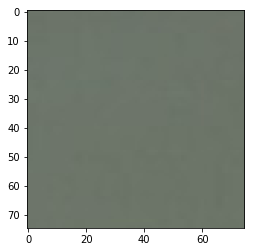

In [169]:
#show model
fig,ax = plt.subplots(1)
ax.imshow(model)

**backprojection calculations**

In [170]:
#convert to hsv (hue, saturation, value)
hsvm = cv2.cvtColor(model,cv2.COLOR_BGR2HSV)

In [171]:
#calculate histogram of model
histm = cv2.calcHist([hsvm],[0, 1], None, [180, 256], [0, 180, 0, 256])

In [172]:
#normalize histogram values to 0-255, this makes it 0-255 x 0-255
cv2.normalize(histm,histm,0,255,cv2.NORM_MINMAX)
#apply backprojection
dst = cv2.calcBackProject([hsvt],[0,1],histm,[0,180,0,256],1)

In [173]:
#convolute with circular disc
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
dst = cv2.filter2D(dst,-1,disc,dst)

In [174]:
#threshold and binary AND
threshold = 0 #everything
ret,thresh = cv2.threshold(dst,threshold,255,0)
thresh = cv2.merge((thresh,thresh,thresh))
res = cv2.bitwise_and(target,thresh) #get colour from image to show as result

**how many pixels in the detected lake area?**

In [175]:
#grey version
threshg = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

#histogram of this
hist = cv2.calcHist([threshg],[0],None,[256],[0,256])

#lake pixels are white so last element of array
whtpx = float(hist[255])
whtpct = float(hist[255]/(hist[255]+hist[0]))

print ('lake pixels = ', whtpx)
print ('lake percent = ', whtpct*100)

lake pixels =  34411.0
lake percent =  16.386190056800842


**show the selected area on the original image of the lake**

In [176]:
#make a mask from the grey threshold image
ret, mask = cv2.threshold(threshg, 10, 255, cv2.THRESH_BINARY)

In [177]:
#set opacity based on the threshold image using the mask, so can plot lake area on image without covering the background
b_channel, g_channel, r_channel = cv2.split(thresh)
alpha_channel = mask
thresh_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

In [178]:
#determine boundary of the mask as a contour, so can plot on image
im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

**plot image and lake boundary**

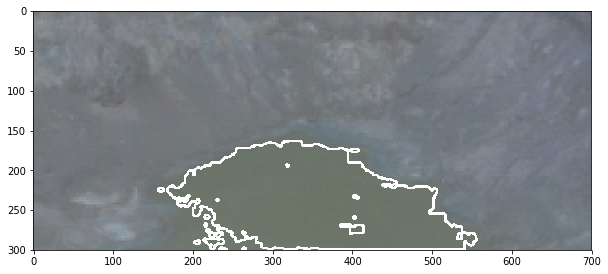

In [180]:
fig,ax = plt.subplots(figsize=(10,5))
ax.imshow(target)

#ax.imshow(thresh_BGRA) #plot lake area

#show contour
cv2.drawContours(target, contours, -1, (255,255,255), 2);

plt.savefig('lake_area.jpg')